# Задача 5. Обучение без учителя

Щека Дмитрий Вадимович, 24.М41

Вроде, все поставленные задачи выполнил, так что претендую на 10 баллов

Единственный минус, не нашел датасет с 50 признаками, час на каггле искал, максимум 30:
https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis/data

Аттрибуты
People
- ID: Customer's unique identifier
- Year_Birth: Customer's birth year
- Education: Customer's education level
- Marital_Status: Customer's marital status
- Income: Customer's yearly household income
- Kidhome: Number of children in customer's household
- Teenhome: Number of teenagers in customer's household
- Dt_Customer: Date of customer's enrollment with the company
- Recency: Number of days since customer's last purchase
- Complain: 1 if the customer complained in the last 2 years, 0 otherwise

Products:
- MntWines: Amount spent on wine in last 2 years
- MntFruits: Amount spent on fruits in last 2 years
- MntMeatProducts: Amount spent on meat in last 2 years
- MntFishProducts: Amount spent on fish in last 2 years
- MntSweetProducts: Amount spent on sweets in last 2 years
- MntGoldProds: Amount spent on gold in last 2 years

Promotion
- NumDealsPurchases: Number of purchases made with a discount
- AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
- AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
- AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
- AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
- AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
- Response: 1 if customer accepted the offer in the last campaign, 0 otherwise

Place
- NumWebPurchases: Number of purchases made through the company’s website
- NumCatalogPurchases: Number of purchases made using a catalogue
- NumStorePurchases: Number of purchases made directly in stores
- NumWebVisitsMonth: Number of visits to company’s website in the last month

Надо выполнить кластеризацию, разбить клиентов на группы.

In [1]:
import pandas as pd
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.utils import check_array, check_random_state
from sklearn.utils.validation import check_is_fitted
import time
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import NearestNeighbors
import numpy.typing as npt
from sklearn.manifold import TSNE

In [2]:
df = pd.read_csv("marketing_campaign.csv", sep='\t')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [4]:
df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

# EDA и Feature engineering

In [5]:
# Не очень полезные колонки
print(df['Z_CostContact'].nunique())
print(df['Z_Revenue'].nunique())
df.drop(['ID', 'Z_CostContact', 'Z_Revenue'], axis=1, inplace=True)

1
1


In [6]:
# Даты преобразуем в количественные признаки
df['Dt_Customer'] = pd.to_datetime(df.Dt_Customer, format="%d-%m-%Y")
latest_date = df['Dt_Customer'].max()
df['Days_is_client'] = (latest_date - df['Dt_Customer']).dt.days
df['Age'] = df['Dt_Customer'].dt.year - df['Year_Birth']
df.drop(['Dt_Customer', 'Year_Birth'], axis=1, inplace=True)
df.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Days_is_client,Age
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,7,0,0,0,0,0,0,1,663,55
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,...,5,0,0,0,0,0,0,0,113,60
2,Graduation,Together,71613.0,0,0,26,426,49,127,111,...,4,0,0,0,0,0,0,0,312,48
3,Graduation,Together,26646.0,1,0,26,11,4,20,10,...,6,0,0,0,0,0,0,0,139,30
4,PhD,Married,58293.0,1,0,94,173,43,118,46,...,5,0,0,0,0,0,0,0,161,33


In [7]:
# Преобразуем категориальные значения
categorical_columns = df.select_dtypes('object')

for column in categorical_columns:
    value_counts = df[column].value_counts()
    print(value_counts)
    print("\n")

Education
Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: count, dtype: int64


Marital_Status
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64




In [8]:
# Расширим и объединим группы в 'Marital_Status'
df['Marital_Status'] = df['Marital_Status'].replace(['Married', 'Together'], 'Partner')
df['Marital_Status'] = df['Marital_Status'].replace(['Divorced', 'Widow', 'Alone', 'YOLO', 'Absurd'], 'Single')

# Расширим и объединим группы в 'Education'
df['Education'] = df['Education'].replace(['PhD', 'Master'], 'Postgraduate')  
df['Education'] = df['Education'].replace(['2n Cycle', 'Graduation'], 'Graduate')
df['Education'] = df['Education'].replace(['Basic'], 'Undergraduate')

for column in categorical_columns:
    print(f"Unique values in {column}:")
    print(df[column].unique())
    print("\n")


Unique values in Education:
['Graduate' 'Postgraduate' 'Undergraduate']


Unique values in Marital_Status:
['Single' 'Partner']




In [9]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Encode the 'Education' column
df['Education_Encoded'] = label_encoder.fit_transform(df['Education'])
df.drop(['Education'], axis=1, inplace=True)

# Encode the 'Marital_Status' column
df['Marital_Status_Encoded'] = label_encoder.fit_transform(df['Marital_Status'])
df.drop(['Marital_Status'], axis=1, inplace=True)
df.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Days_is_client,Age,Education_Encoded,Marital_Status_Encoded
0,58138.0,0,0,58,635,88,546,172,88,88,...,0,0,0,0,0,1,663,55,0,1
1,46344.0,1,1,38,11,1,6,2,1,6,...,0,0,0,0,0,0,113,60,0,1
2,71613.0,0,0,26,426,49,127,111,21,42,...,0,0,0,0,0,0,312,48,0,0
3,26646.0,1,0,26,11,4,20,10,3,5,...,0,0,0,0,0,0,139,30,0,0
4,58293.0,1,0,94,173,43,118,46,27,15,...,0,0,0,0,0,0,161,33,1,0


In [10]:
# Сгруппируем некоторые колонки в одну
df['Kids'] = df['Kidhome'] + df['Teenhome']
df.drop(['Kidhome', 'Teenhome'], axis=1, inplace=True)
df['Expenses'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']
df.drop(['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'], axis=1, inplace=True)
df['TotalAcceptedCmp'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5']
df.drop(['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5'], axis=1, inplace=True)
df['TotalNumPurchases'] = df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases'] + df['NumDealsPurchases']
df.drop(['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumDealsPurchases'], axis=1, inplace=True)
df.head()

,Income,Recency,NumWebVisitsMonth,Complain,Response,Days_is_client,Age,Education_Encoded,Marital_Status_Encoded,Kids,Expenses,TotalAcceptedCmp,TotalNumPurchases
0,58138.0,58,7,0,1,663,55,0,1,0,1617,0,25
1,46344.0,38,5,0,0,113,60,0,1,2,27,0,6
2,71613.0,26,4,0,0,312,48,0,0,0,776,0,21
3,26646.0,26,6,0,0,139,30,0,0,1,53,0,8
4,58293.0,94,5,0,0,161,33,1,0,1,422,0,19


In [11]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [12]:
categorical_columns = [col for col in df.columns if 2 <= df[col].nunique() < 10]
numerical_columns = [col for col in df.select_dtypes(include=['number']).columns 
                     if col not in categorical_columns]

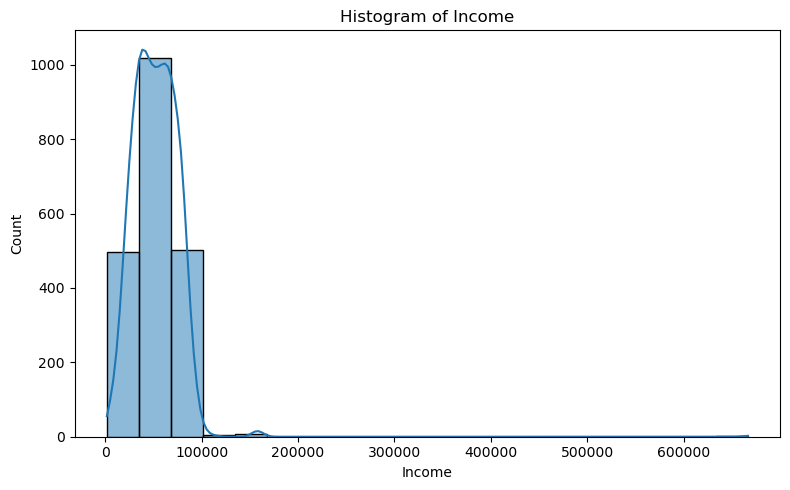

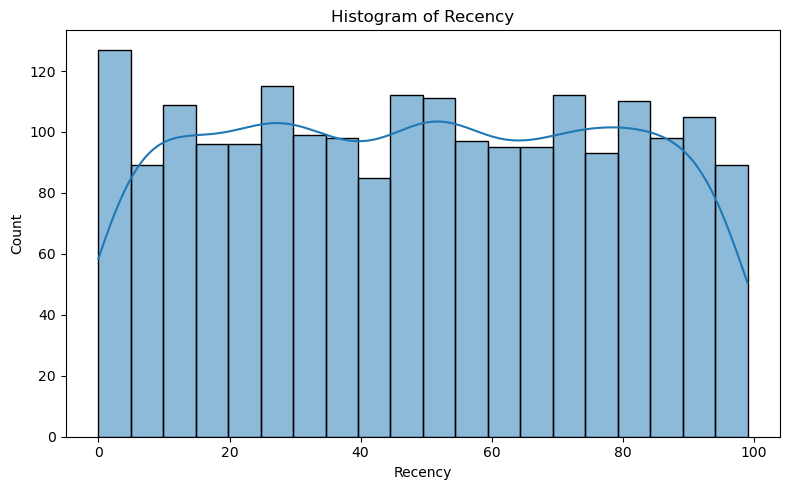

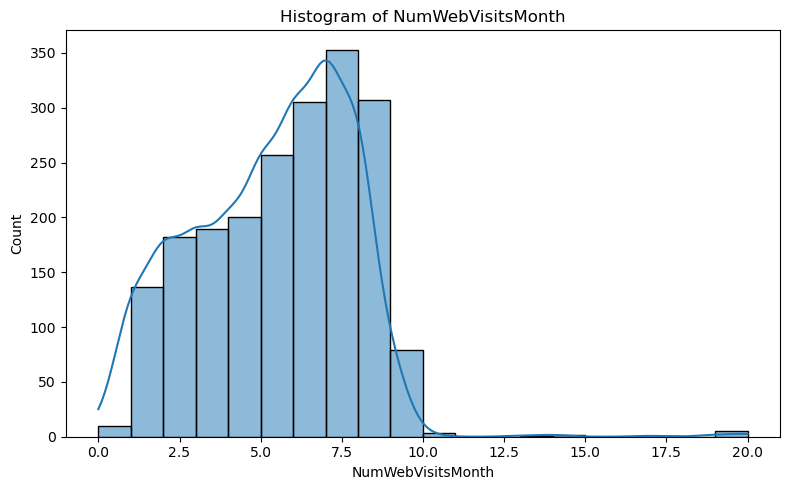

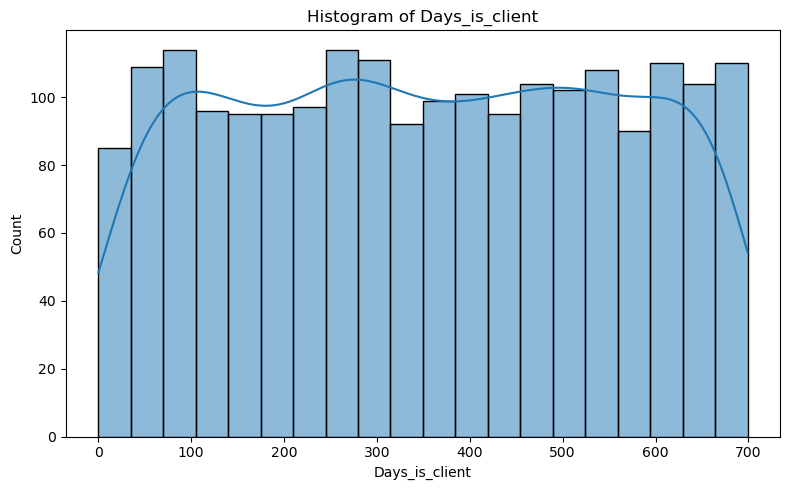

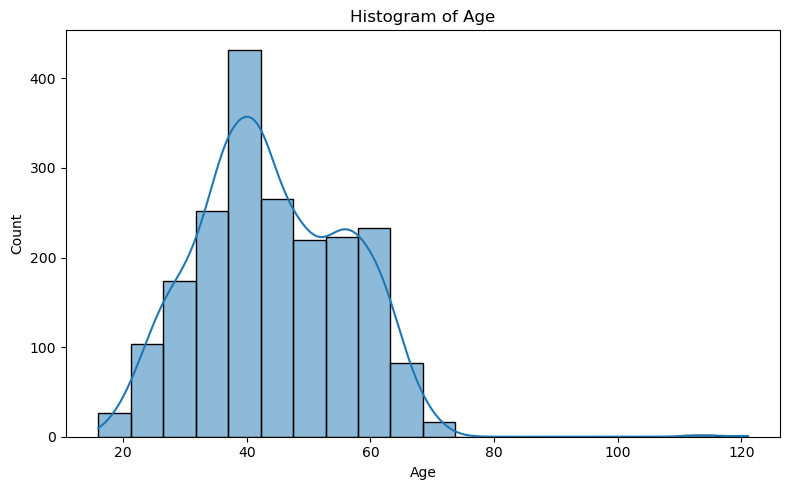

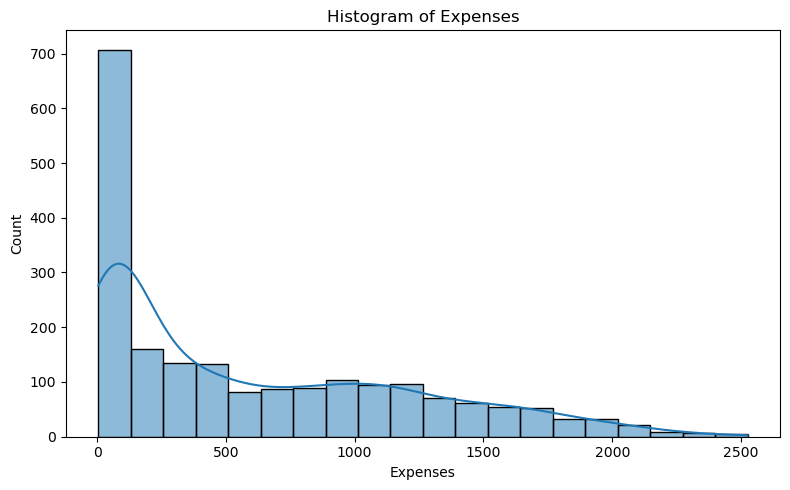

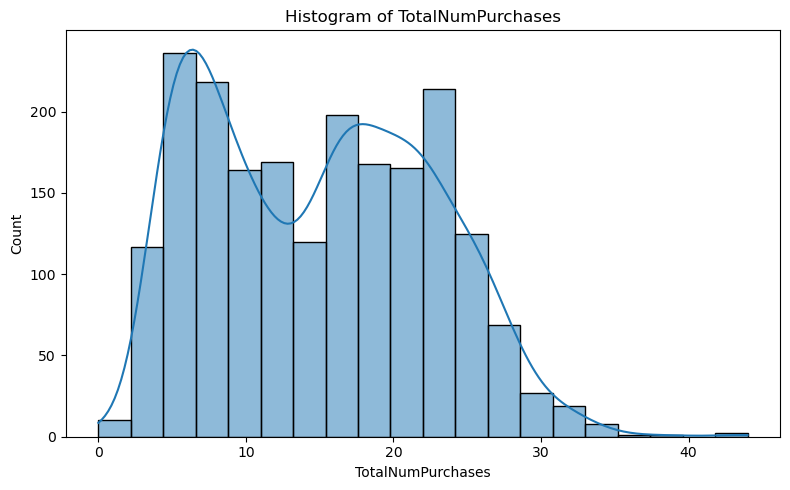

In [13]:
for column in numerical_columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=column, kde=True, bins=20)
    plt.title(f'Histogram of {column}')
    
    plt.tight_layout()
    plt.show()

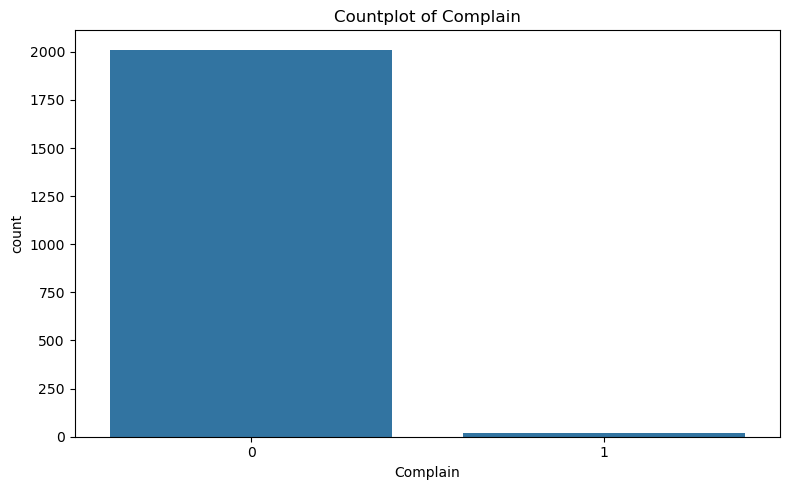

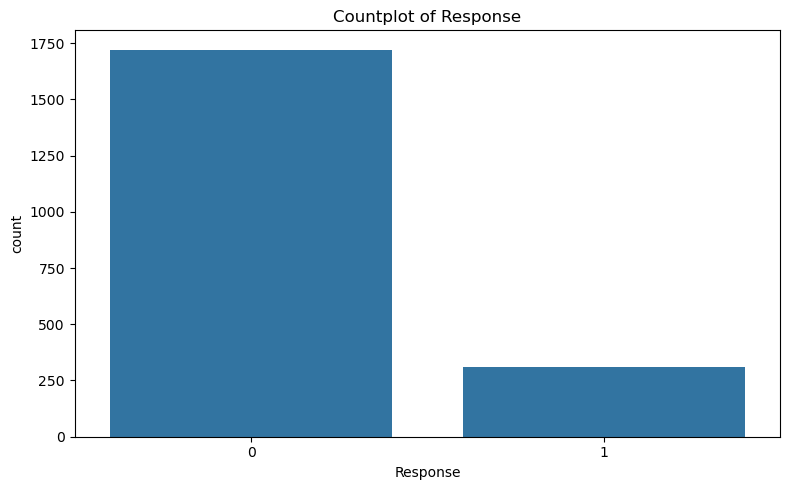

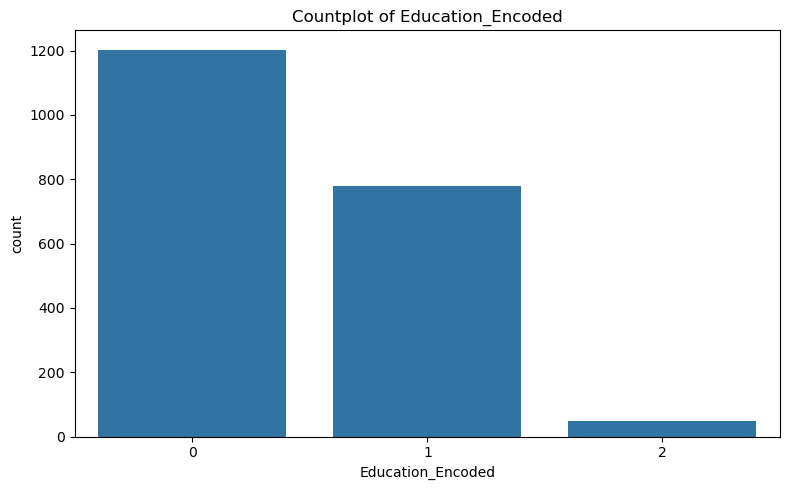

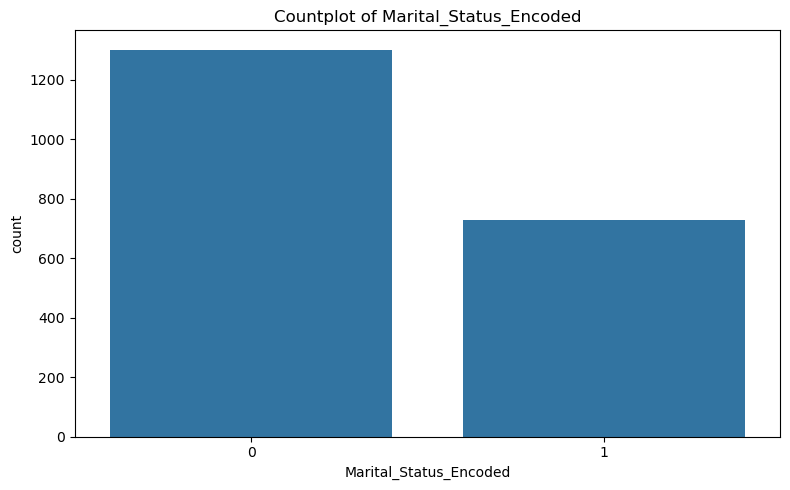

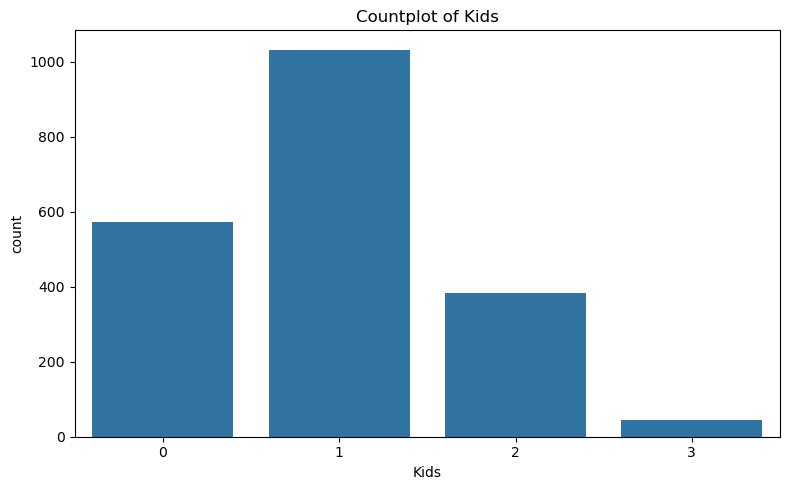

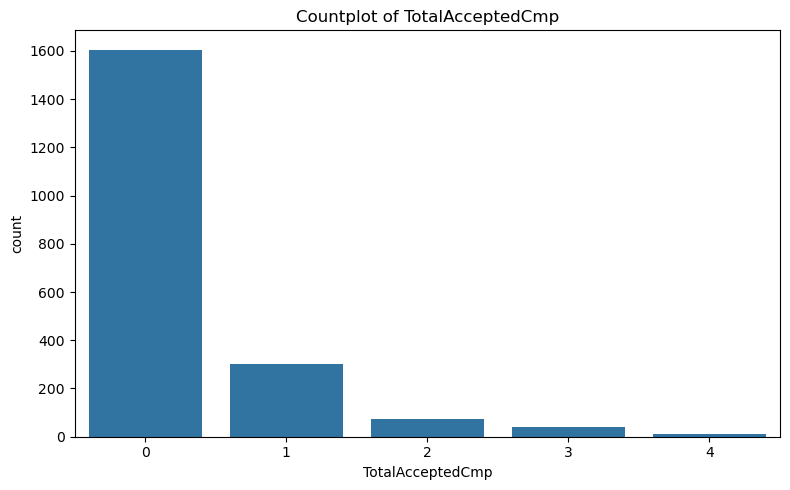

In [14]:
for column in categorical_columns:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x=column)
    plt.title(f'Countplot of {column}')
    
    plt.tight_layout()
    plt.show()

In [15]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Реализация KMeans

In [16]:
class CustomKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters: int = 10, tol: float = 1e-4, random_state=None):
        if not isinstance(n_clusters, int) or n_clusters <= 0:
            raise ValueError(f"n_clusters must be a positive integer, got {n_clusters}")
        if not isinstance(tol, float) or tol < 0:
            raise ValueError(f"tol must be a non-negative float, got {tol}")
        
        self.n_clusters = n_clusters
        self.tol = tol
        self.random_state = random_state

    def _get_labels(self, X: npt.NDArray) -> npt.NDArray:
        dists_to_centers = np.linalg.norm(X[:, None] - self.cluster_centers_, axis=2)
        return np.argmin(dists_to_centers, axis=1)

    def fit(self, X: npt.ArrayLike, y=None) -> "CustomKMeans":
        X = check_array(X)
        
        random_state = check_random_state(self.random_state)

        n_samples, n_features = X.shape
        self.n_features_in_ = n_features
        initial_idxs = random_state.choice(n_samples, self.n_clusters, replace=False)
        self.cluster_centers_ = X[initial_idxs]

        max_shift = np.inf
        while max_shift > self.tol:
            self.labels_ = self._get_labels(X)

            new_centers = np.array([X[self.labels_ == i].mean(axis=0) for i in range(self.n_clusters)])

            max_shift = np.max(np.linalg.norm(self.cluster_centers_ - new_centers, axis=1))
            self.cluster_centers_ = new_centers

        return self

    def predict(self, X: npt.ArrayLike) -> npt.NDArray:
        check_is_fitted(self)
        X = check_array(X)
        return self._get_labels(X)

# Обучение и оценка моделей

В качестве метрики возьмём Silhouette

In [17]:
def evaluate_model(model_class, param_grid, X, model_name):
    best_params = None
    best_silhouette = -1
    best_training_time = None
    best_model = None
    
    for params in ParameterGrid(param_grid):
        model = model_class(**params)
        start_time = time.time()
        labels = model.fit_predict(X)
        end_time = time.time()

        silhouette = silhouette_score(X, labels) if len(np.unique(labels)) > 1 else -1
        training_time = end_time - start_time

        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_params = params
            best_training_time = training_time
            best_model = model
    
    return (model_name, best_params, best_silhouette, best_training_time, best_model)



In [18]:
X = scaled_data

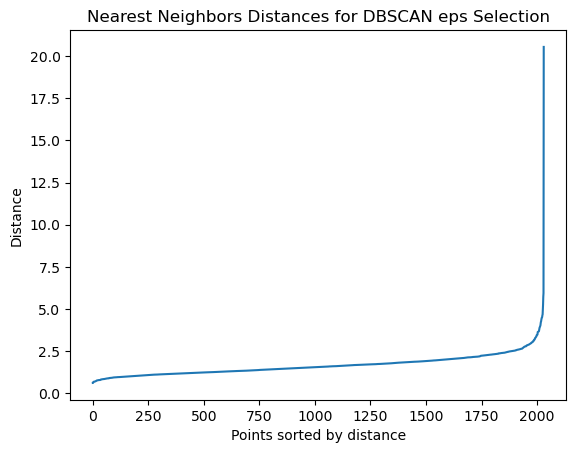

In [19]:
# посчитаем средние расстояния, чтобы выбрать сетку эпсилонов для dbscan
def plot_eps_decision(X):
    neighbors = NearestNeighbors(n_neighbors=5)
    neighbors_fit = neighbors.fit(X)
    distances, indices = neighbors_fit.kneighbors(X)

    distances = np.sort(distances[:, 4], axis=0)
    plt.plot(distances)
    plt.title('Nearest Neighbors Distances for DBSCAN eps Selection')
    plt.ylabel('Distance')
    plt.xlabel('Points sorted by distance')
    plt.show()

plot_eps_decision(X)

In [20]:
kmeans_grid = {'n_clusters': [2, 3, 4, 5], 'tol': [1e-4, 1e-3]}
dbscan_grid = {'eps': [2.5, 2.7, 2.9, 3.0], 'min_samples': [3, 5, 7]}

all_results = []
all_results.append(evaluate_model(CustomKMeans, kmeans_grid, X, 'CustomKMeans'))
all_results.append(evaluate_model(KMeans, kmeans_grid, X, 'KMeans'))
all_results.append(evaluate_model(DBSCAN, dbscan_grid, X, 'DBSCAN'))

results_df = pd.DataFrame(all_results, columns=['Model', 'Params', 'Silhouette Score', 'Training Time', 'Best Model'])

/tmp/ipykernel_20698/4257262652.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(results_df['Model'], rotation=45)
/tmp/ipykernel_20698/4257262652.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(results_df['Model'], rotation=45)


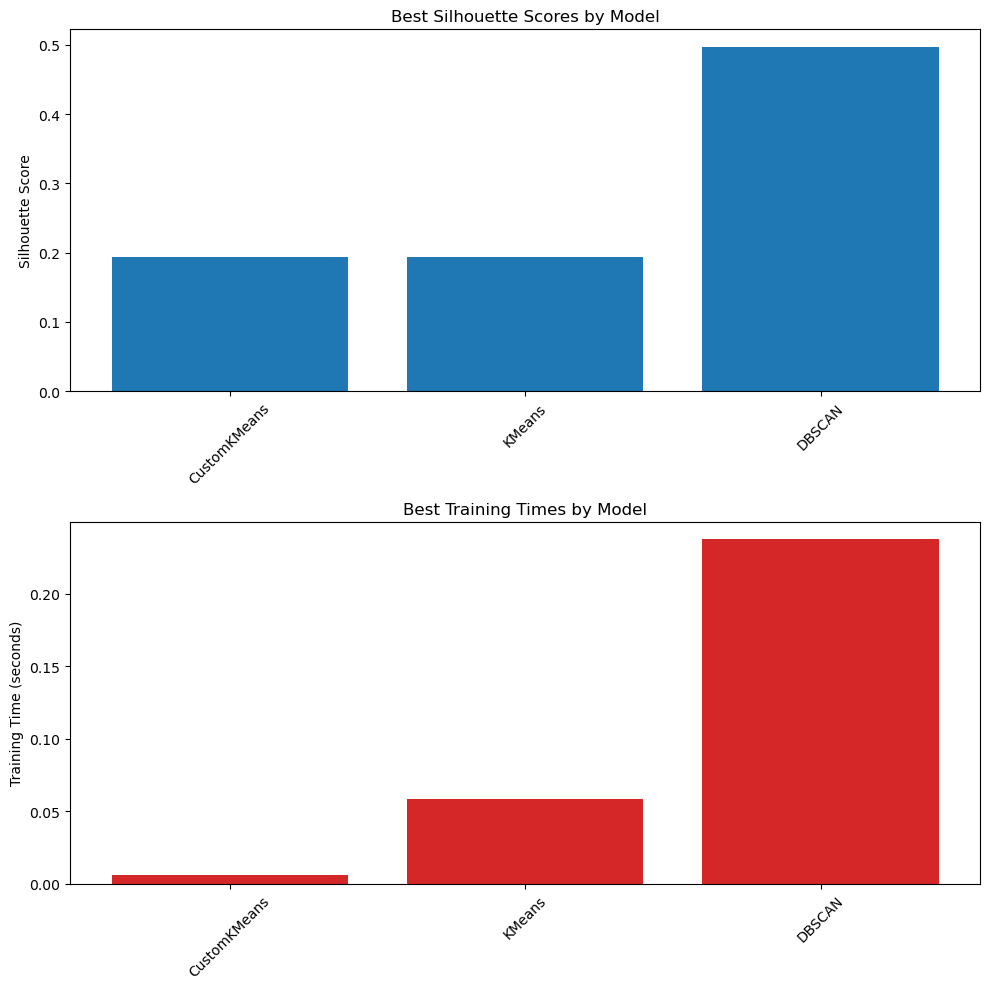

In [21]:
def plot_clustering_results_separate(results_df):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

    ax1.set_title('Best Silhouette Scores by Model')
    ax1.set_ylabel('Silhouette Score')
    ax1.bar(results_df['Model'], results_df['Silhouette Score'], color='tab:blue')
    ax1.set_xticklabels(results_df['Model'], rotation=45)

    ax2.set_title('Best Training Times by Model')
    ax2.set_ylabel('Training Time (seconds)')
    ax2.bar(results_df['Model'], results_df['Training Time'], color='tab:red')
    ax2.set_xticklabels(results_df['Model'], rotation=45)

    plt.tight_layout()
    plt.show()

plot_clustering_results_separate(results_df)

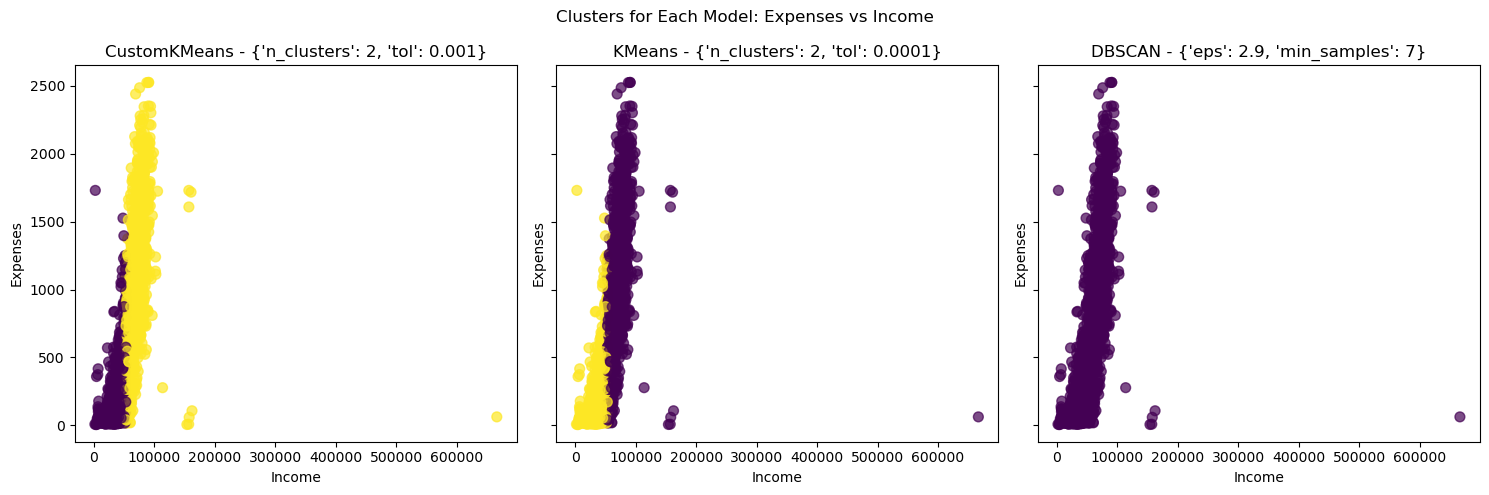

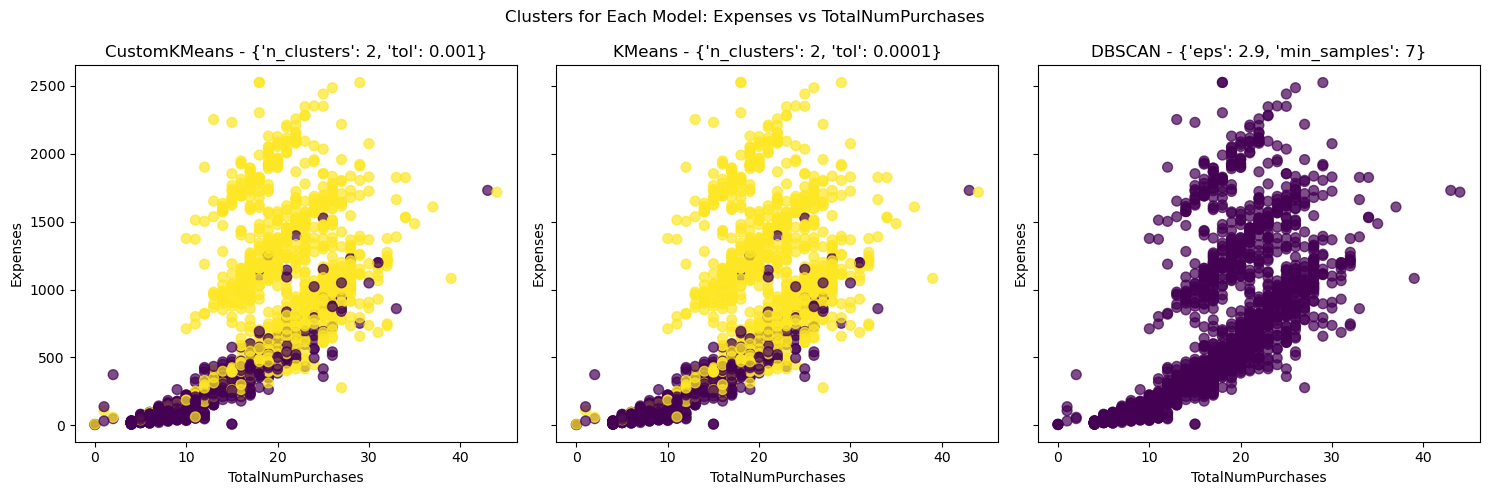

In [22]:
def plot_clusters_expenses_income(results_df, X, df, y_name, x_name):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
    axes = axes.flatten()

    expenses_idx = df.columns.get_loc(y_name)
    income_idx = df.columns.get_loc(x_name)

    for i, (index, row) in enumerate(results_df.iterrows()):
        ax = axes[i]
        model = row['Best Model']
        labels = model.fit_predict(X)
        
        ax.scatter(X[:, income_idx], X[:, expenses_idx], c=labels, cmap='viridis', s=50, alpha=0.7)
        ax.set_title(f'{row["Model"]} - {row["Params"]}')
        ax.set_xlabel(x_name)
        ax.set_ylabel(y_name)

    plt.suptitle(f'Clusters for Each Model: {y_name} vs {x_name}')
    plt.tight_layout()
    plt.show()

X_transformed = scaler.inverse_transform(X)
plot_clusters_expenses_income(results_df, X_transformed, df, 'Expenses', 'Income')
plot_clusters_expenses_income(results_df, X_transformed, df, 'Expenses', 'TotalNumPurchases')

# Применим PCA

In [23]:
def apply_pca(X, n_components=2):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    return X_pca

In [24]:
X_pcas = {}

def apply_pca_and_evaluate(models, pca_components_list, X):
    all_results = []

    for n_components in pca_components_list:
        X_pca = apply_pca(X, n_components)
        X_pcas[n_components] = X_pca
        
        for model_name, model_class, param_grid in models:
            result = evaluate_model(model_class, param_grid, X_pca, f'{model_name} (PCA {n_components})')
            all_results.append(result)
    
    return all_results

models = [
    ('CustomKMeans', CustomKMeans, {'n_clusters': [2, 3, 4, 5], 'tol': [1e-4, 1e-3]}),
    ('KMeans', KMeans, {'n_clusters': [2, 3, 4, 5], 'tol': [1e-4, 1e-3]}),
    ('DBSCAN', DBSCAN, {'eps': [0.1, 0.3, 0.5, 0.7, 1.0], 'min_samples': [3, 5, 7]})
]

pca_components_list = [2, 3, 5]
all_results = apply_pca_and_evaluate(models, pca_components_list, X)
results_df = pd.DataFrame(all_results, columns=['Model', 'Params', 'Silhouette Score', 'Training Time', 'Best Model'])

/tmp/ipykernel_20698/4257262652.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(results_df['Model'], rotation=45)
/tmp/ipykernel_20698/4257262652.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(results_df['Model'], rotation=45)


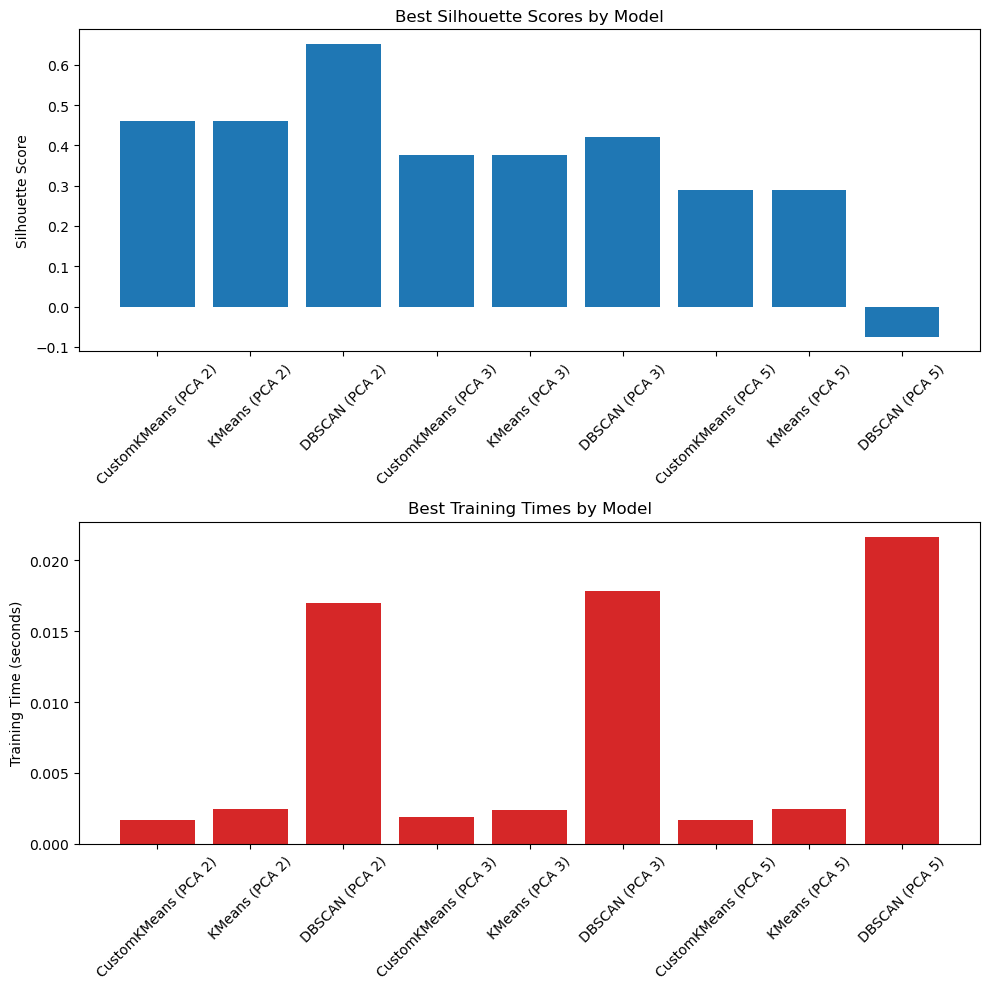

In [25]:
plot_clustering_results_separate(results_df)

# Применим PCA и T-SNE и визуализируем данные

/tmp/ipykernel_20698/988255569.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter_pca = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
/tmp/ipykernel_20698/988255569.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter_tsne = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)


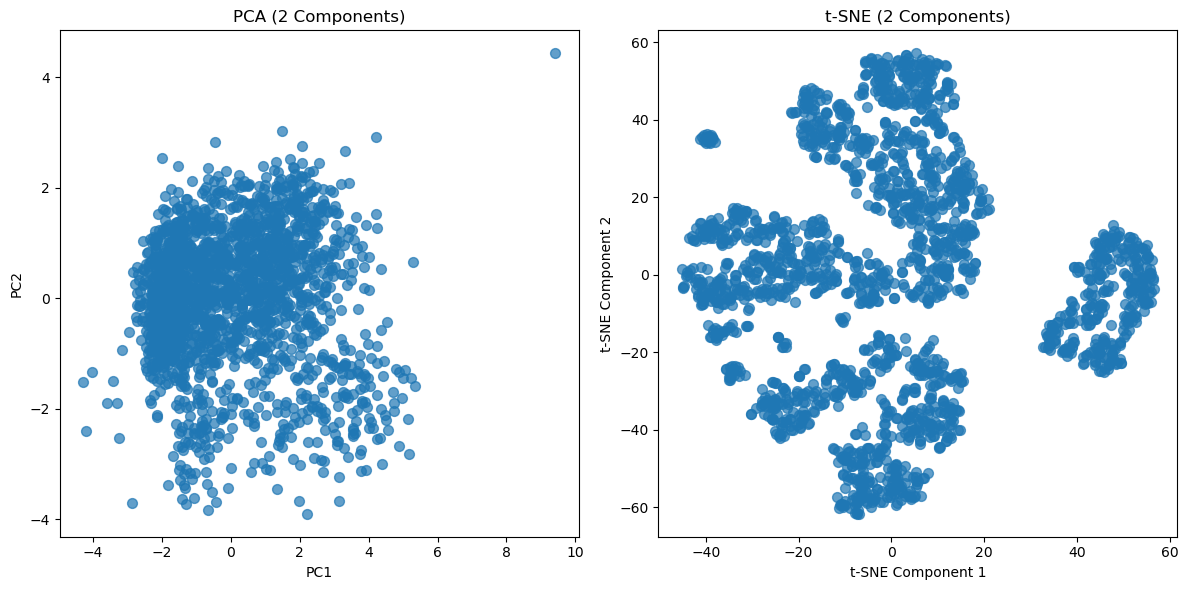

In [26]:
def apply_tsne(X, n_components=2, perplexity=30.0, random_state=42):
    tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=random_state)
    X_tsne = tsne.fit_transform(X)
    return X_tsne

def plot_pca_tsne(X_pca, X_tsne, labels=None):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    scatter_pca = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
    axes[0].set_title('PCA (2 Components)')
    axes[0].set_xlabel('PC1')
    axes[0].set_ylabel('PC2')

    if labels is not None:
        fig.colorbar(scatter_pca, ax=axes[0], label="Cluster Label")

    scatter_tsne = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
    axes[1].set_title('t-SNE (2 Components)')
    axes[1].set_xlabel('t-SNE Component 1')
    axes[1].set_ylabel('t-SNE Component 2')

    if labels is not None:
        fig.colorbar(scatter_tsne, ax=axes[1], label="Cluster Label")

    plt.tight_layout()
    plt.show()

X_pca = apply_pca(X)
X_tsne = apply_tsne(X)

plot_pca_tsne(X_pca, X_tsne, labels=None)

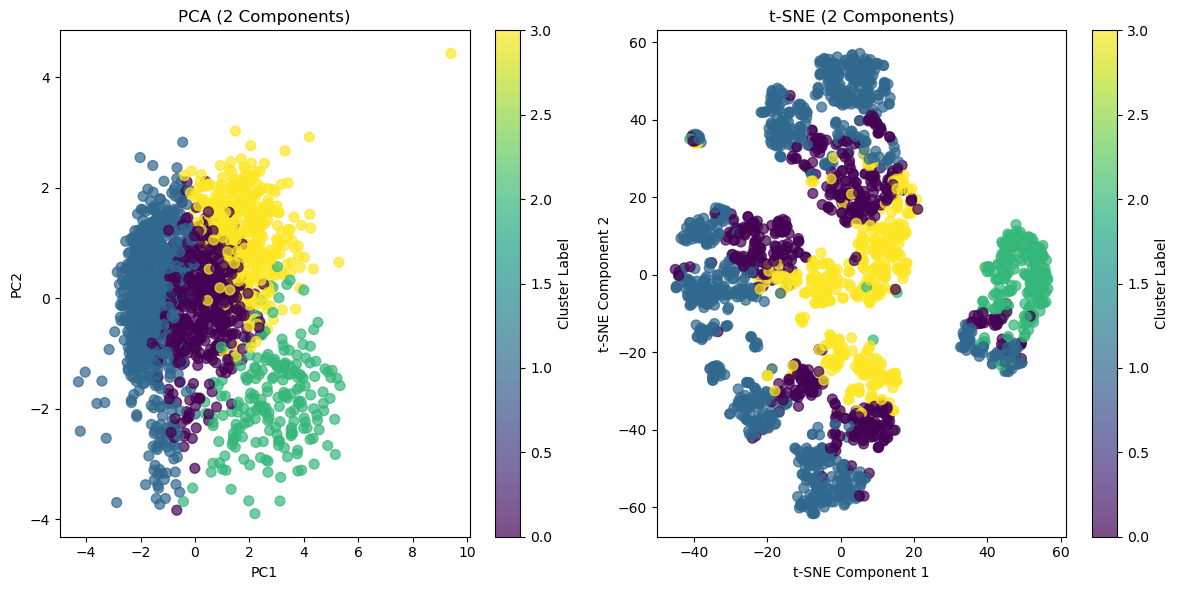

In [27]:
custom_kmeans = CustomKMeans(n_clusters=4, random_state=42)
clusters = custom_kmeans.fit(X)
cluster_labels = custom_kmeans.labels_
plot_pca_tsne(X_pca, X_tsne, labels=cluster_labels)